### Simple Analysis of 2015 Flight Delay data from Kaggle

Here we analyze 2015 flights within the US. The data are obtained from Kaggle and include three files:
1. airports.csv
2. airlines.csv
3. flights.csv
The airports.csv file was modified to include the timezone (David Olson format) for each airport. This will be useful for joining weather data which is specified in UTC time.

We begin by loading required libraries and cleaning the data. The time columns in the flights dataframe are listed as integers with last two digits corresponding to minutes and the first one/two corresponding to hours. We convert these to a time object using the lubridate package.


In [3]:
listOfPackages = c("plyr", "dplyr", "lubridate", "ggplot2", "data.table", "maps",
                  "geosphere", "tidyr", "repr", "cowplot", "ggrepel", "gridExtra")
newPackages <- listOfPackages[!(listOfPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages)

library(plyr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(data.table)
library(maps)
library(geosphere)
library(tidyr)
library(repr)
library(cowplot)
library(ggrepel)
library(gridExtra)

In [4]:
#Helper functions to process data
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

convertTime = function(numberTimes) {
  hours = numberTimes %/% 100
  minutes = numberTimes %% 100
  time = substr(as.POSIXct(paste(hours, minutes), format = '%H%M'), 12, 16)
  return(time)
}

combineDate = function(year, month, day) {
  return(as.Date(paste(year, month, day, sep = "-"), format="%Y-%m-%d"))
}

combineDateTime = function(year, month, day, numberTimes) {
  times = convertTime(numberTimes)
  dates = combineDate(year, month, day)
  fulldatetime = as.POSIXct(paste(dates, times), format="%Y-%m-%d %H:%M")
  return(fulldatetime)
}

In [5]:
setwd("C:/Users/jordanna/Documents/FlightDelayProject")

flights = read.table(file("data/flights.csv"), header = T, sep = ",", 
                    stringsAsFactors = FALSE)

In [6]:
#nrow(na.omit(flights))
#colnames(flights)
cat('Missing values:')
colSums(is.na(flights))
cat(c('Number of flights:', nrow(flights)))
#summary(flights)

nAirports = length(unique(flights$ORIGIN_AIRPORT))

Missing values:

YEAR               MONTH                 DAY         DAY_OF_WEEK 
                  0                   0                   0                   0 
            AIRLINE       FLIGHT_NUMBER         TAIL_NUMBER      ORIGIN_AIRPORT 
                  0                   0                   0                   0 
DESTINATION_AIRPORT SCHEDULED_DEPARTURE      DEPARTURE_TIME     DEPARTURE_DELAY 
                  0                   0               86153               86153 
           TAXI_OUT          WHEELS_OFF      SCHEDULED_TIME        ELAPSED_TIME 
              89047               89047                   6              105071 
           AIR_TIME            DISTANCE           WHEELS_ON             TAXI_IN 
             105071                   0               92513               92513 
  SCHEDULED_ARRIVAL        ARRIVAL_TIME       ARRIVAL_DELAY            DIVERTED 
                  0               92513              105071                   0 
          CANCELLED CANCELLATION_REASON    AIR_SYSTEM_DELAY      SECURITY_DELAY 
                  0                   0             4755640             4755640 
      AIRLINE_DELAY LATE_AIRCRAFT_DELAY       WEATHER_DELAY 
            4755640             4755640             4755640

Number of flights: 5819079

In [7]:
#nrow(na.omit(flights))
#colSums(is.na(flights))

October flights use five-digit airport codes. Here we replace them with three-letter IATA codes.

The translation table was constructed by matching flights with numeric airport codes to those with IATA codes by comparing distance, origin airport, destination airport, airline and flight number.

In [8]:
airportCodeTable = read.table(file("data/AirportTranslationTable.txt"), sep = "\t", header = T,
                             stringsAsFactors = FALSE)
for (i in 1:nrow(airportCodeTable)) {
  numberCode = as.character(airportCodeTable[i,1])
  flights$ORIGIN_AIRPORT[flights$ORIGIN_AIRPORT == numberCode] = airportCodeTable[i,2]
  flights$DESTINATION_AIRPORT[flights$DESTINATION_AIRPORT == numberCode] = airportCodeTable[i,2]
}

nAirports = length(unique(flights$ORIGIN_AIRPORT))

In [9]:
#Most frequent origin airports in the dataset

totalFlights = nrow(flights)
allFlightAirports = unique(as.vector(as.matrix(flights[1:nrow(flights), c(8,9)])))
allFlightAirports = as.character(allFlightAirports)
originFreq = flights %>%
  group_by(ORIGIN_AIRPORT) %>%
  summarise (n = n()) %>%
  mutate(freq = n / sum(n)) %>%
  arrange(desc(freq))


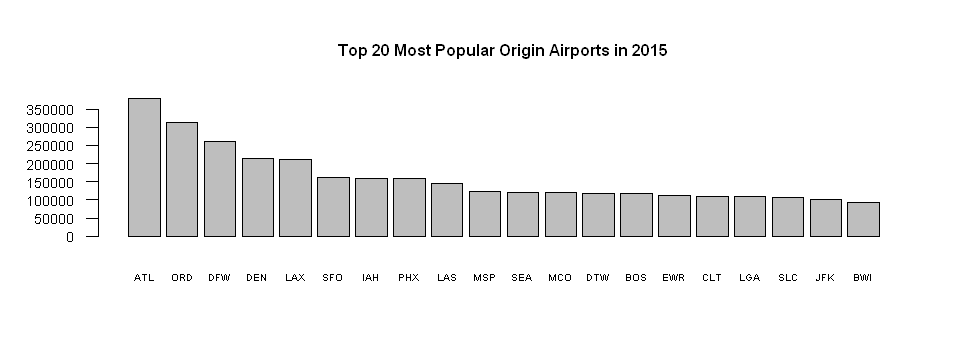

In [10]:
originTable = table(flights$ORIGIN_AIRPORT)
originTable = originTable[order(originTable, decreasing = T)]

destFreq = table(flights$DESTINATION_AIRPORT)
destFreq = destFreq[order(destFreq, decreasing = T)]

options(repr.plot.width=8, repr.plot.height=3)
par(las=1)
barplot(originTable[1:20], cex.names = 0.5, cex.axis = 0.7,
       main = "Top 20 Most Popular Origin Airports in 2015", cex.main = 0.8)


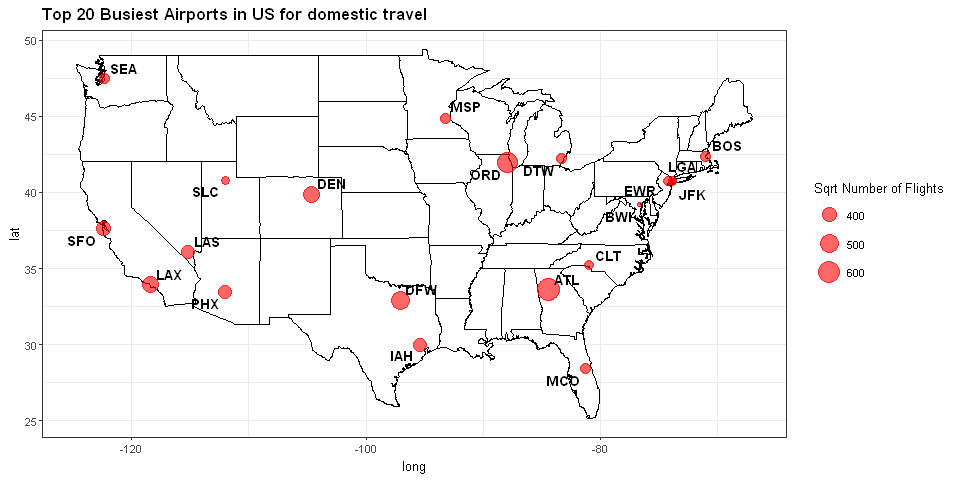

In [11]:
airportLocations = read.table("data/airports_withtimezone.txt", header = T, sep = "\t", quote = "", comment.char = "")
numAirports = 20


popAirportPointsDF = data.frame(AirportCode = character(numAirports ),
                              Longitude = double(numAirports ),
                              Latitude = double(numAirports ), 
                              flights = integer(numAirports ),  stringsAsFactors = FALSE)
popAirportPointsDF$AirportCode[1:numAirports] = originFreq$ORIGIN_AIRPORT[1:numAirports]
popAirportPointsDF$flights[1:numAirports] = originFreq$n[1:numAirports ]

for (i in 1:numAirports) {
  airport = as.character(popAirportPointsDF$AirportCode[i])  
  popAirportPointsDF$Longitude[i] = airportLocations[as.character(airportLocations$IATA_CODE) == airport, 7]
  popAirportPointsDF$Latitude[i] =  airportLocations[as.character(airportLocations$IATA_CODE) == airport, 6]
}
options(repr.plot.width=8, repr.plot.height=4)
usa <- map_data("state")
gg1 <- ggplot() + geom_polygon(data = usa, aes(x = long, y = lat, group = group), 
                               fill = "white", col = "black") + coord_fixed(1.3) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))
gg1 +  geom_point(data = popAirportPointsDF, 
             aes(x = Longitude, y = Latitude, size = sqrt(flights)), 
             color = "red", alpha = 0.6) +
  geom_text_repel(data = popAirportPointsDF, aes(x = Longitude, y = Latitude, label=AirportCode),
            size = 3,fontface = "bold") +
  ggtitle('Top 20 Busiest Airports in US for domestic travel') + 
  theme_bw(base_size = 8) +
  theme(plot.title = element_text(size=10, face = "bold")) + 
  labs(size="Sqrt Number of Flights")


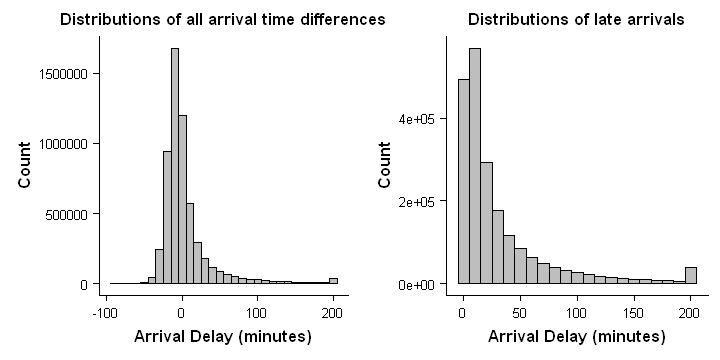

In [12]:
options(repr.plot.width=6, repr.plot.height=3)
delayDist = data.frame(flights$ARRIVAL_DELAY)
colnames(delayDist) = c("ARRIVAL_DELAY")
delayDist$ARRIVAL_DELAY[delayDist$ARRIVAL_DELAY > 200] = 200
delayDist = na.omit(delayDist)
plot1 = ggplot(delayDist, aes(x = ARRIVAL_DELAY)) +
  geom_histogram(binwidth = 10, fill = "grey",col = "black") +
  xlab('Arrival Delay (minutes)') +
  ggtitle('Distributions of all arrival time differences') +
  ylab('Count') +
  theme(plot.title = element_text(size=10,face = "bold")) + 
  theme(legend.position="none") +
  theme(axis.text=element_text(size=8)) +
  theme(axis.title=element_text(size=10, face = "bold")) 
delayDist = data.frame(delayDist[delayDist$ARRIVAL_DELAY > 0,])
colnames(delayDist) = c("ARRIVAL_DELAY")
plot2 = ggplot(delayDist, aes(x = ARRIVAL_DELAY)) +
  geom_histogram(binwidth = 10, fill = "grey",col = "black") +
  xlab('Arrival Delay (minutes)') +
  ggtitle('Distributions of late arrivals') +
  ylab('Count') +
  theme(plot.title = element_text(size=10,face = "bold")) + 
  theme(legend.position="none") +
  theme(axis.text=element_text(size=8)) +
  theme(axis.title=element_text(size=10, face = "bold")) 
grid.arrange(plot1, plot2, ncol = 2)

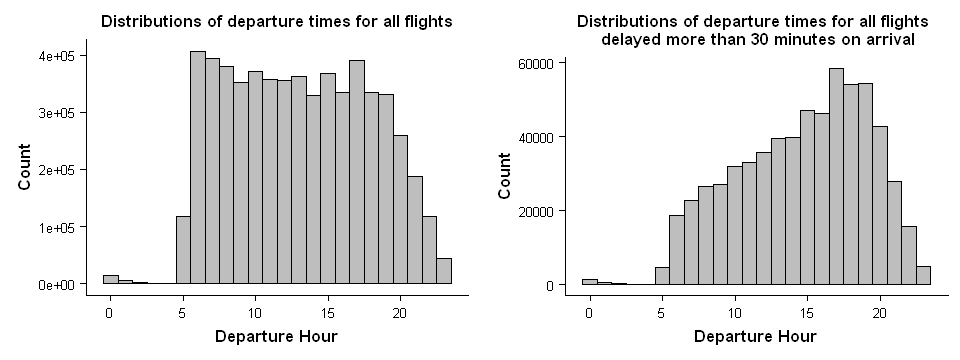

In [13]:
options(repr.plot.width=8, repr.plot.height=3)
flights$departureHour = flights$SCHEDULED_DEPARTURE %/% 100
delayedFlights = flights[(flights$ARRIVAL_DELAY > 30) & !is.na(flights$ARRIVAL_DELAY),]
#colnames(delayedFlights)
plot3 = ggplot(flights, aes(x = departureHour)) +
  geom_histogram(binwidth = 1, fill = "grey",col = "black") +
  xlab('Departure Hour') +
  ggtitle('Distributions of departure times for all flights') +
  ylab('Count') +
  theme(plot.title = element_text(size=10,face = "bold")) + 
  theme(legend.position="none") +
  theme(axis.text=element_text(size=8)) +
  theme(axis.title=element_text(size=10, face = "bold")) 
plot4 = ggplot(delayedFlights, aes(x = departureHour)) +
  geom_histogram(binwidth = 1, fill = "grey",col = "black") +
  xlab('Departure Hour') +
  ggtitle('Distributions of departure times for all flights \n delayed more than 30 minutes on arrival') +
  ylab('Count') +
  theme(plot.title = element_text(size=10,face = "bold")) + 
  theme(legend.position="none") +
  theme(axis.text=element_text(size=8)) +
  theme(axis.title=element_text(size=10, face = "bold")) 
grid.arrange(plot3, plot4, ncol = 2)

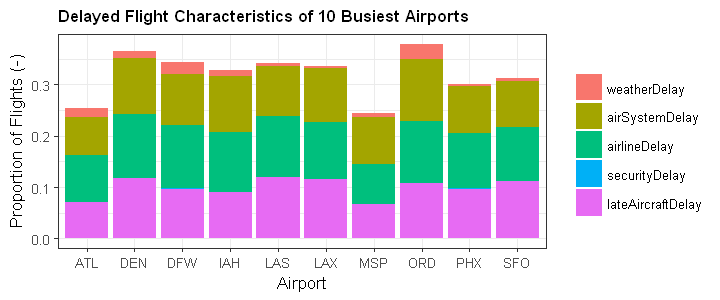

In [14]:
getAirportDelay = function(airport, df) {
    sub.df = df[as.character(df$ORIGIN_AIRPORT) == airport,]
    nFlights = nrow(sub.df)
    weatherDelay = nrow(sub.df[!(is.na(sub.df$WEATHER_DELAY)) & (sub.df$WEATHER_DELAY > 0),])/nFlights
    airSystemDelay = nrow(sub.df[!(is.na(sub.df$AIR_SYSTEM_DELAY)) & (sub.df$AIR_SYSTEM_DELAY > 0),])/nFlights
    airlineDelay = nrow(sub.df[!(is.na(sub.df$AIRLINE_DELAY)) & (sub.df$AIRLINE_DELAY > 0),])/nFlights
    securityDelay = nrow(sub.df[!(is.na(sub.df$SECURITY_DELAY)) & (sub.df$SECURITY_DELAY > 0),])/nFlights
    lateAircraftDelay = nrow(sub.df[!(is.na(sub.df$LATE_AIRCRAFT_DELAY)) & (sub.df$LATE_AIRCRAFT_DELAY > 0),])/nFlights
    return(c(weatherDelay, airSystemDelay, airlineDelay, securityDelay, lateAircraftDelay))
}

topAirportDelays = data.frame(airport = character(),
                              weatherDelay = numeric(),
                              airSystemDelay = numeric(),
                              airlineDelay = numeric(),
                              securityDelay = numeric(),
                              lateAircraftDelay = numeric(),
                              stringsAsFactors = FALSE)
originFreqDF = as.data.frame(originFreq, stringsAsFactors = FALSE)
for (i in 1:10) {
    airport = as.character(originFreqDF[i,1])
    topAirportDelays[i,1] = airport
    topAirportDelays[i,2:6] = getAirportDelay(airport, flights)
}

d = ggplot(data = melt(topAirportDelays, id.var = "airport")) + 
    geom_bar(aes(y = value, x = airport, fill = variable), stat="identity") +
labs(x  = 'Airport', y = 'Proportion of Flights (-)') + theme_bw(base_size=10) + 
ggtitle('Delayed Flight Characteristics of 10 Busiest Airports') +
theme(legend.title = element_blank(), plot.title = element_text(size = 10, face = "bold")) 
options(repr.plot.width=6, repr.plot.height=2.5)
d

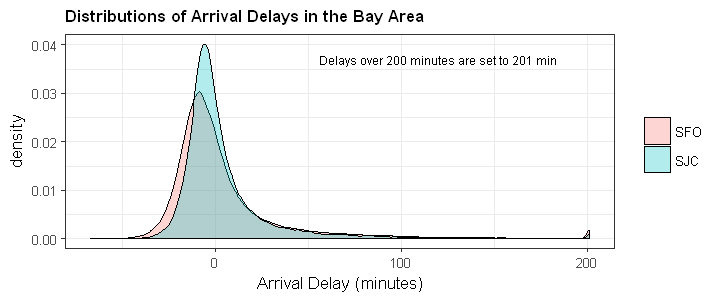

In [15]:
sfoFlightDelays = na.omit(flights$ARRIVAL_DELAY[flights$ORIGIN_AIRPORT == "SFO"])
sjcFlightDelays = na.omit(flights$ARRIVAL_DELAY[flights$ORIGIN_AIRPORT == "SJC"])

location = c(rep("SFO", times = length(sfoFlightDelays)), 
                       rep("SJC", times = length(sjcFlightDelays)))
arrivalDelay = c(sfoFlightDelays, sjcFlightDelays)
densityDF = data.frame(location, arrivalDelay, stringsAsFactors = FALSE)
densityDF$arrivalDelay[densityDF$arrivalDelay >= 200] = 201

ggplot(densityDF, aes(x=arrivalDelay, fill=location)) + geom_density(alpha=0.3) +
xlab('Arrival Delay (minutes)') +
ggtitle('Distributions of Arrival Delays in the Bay Area') + theme_bw(base_size=10) + 
theme(legend.title = element_blank(), plot.title = element_text(size = 10, face = "bold")) +
annotate("text", label = "Delays over 200 minutes are set to 201 min", 
         x = 120, y = 0.037, color = "black", size = 2.5)

In [16]:
#Summarise most popular destination for each origin airport#Summari 
topAirports = originFreqDF[1:20,1]
popDests = flights %>%
  filter(flights$ORIGIN_AIRPORT %in% topAirports) %>%
  group_by(ORIGIN_AIRPORT) %>%
  summarise(popDestination = Mode(DESTINATION_AIRPORT))

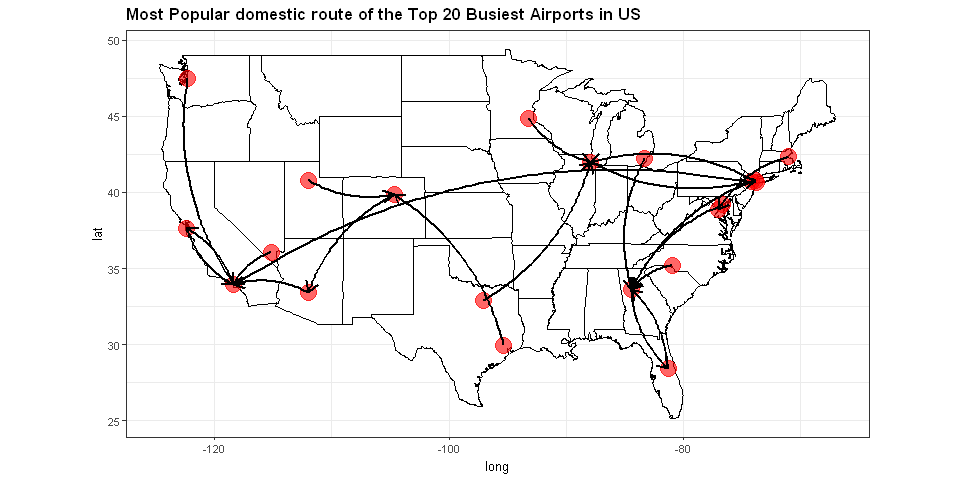

In [18]:
#head(popAirportPointsDF)
for (i in 1:numAirports) {
  airport = as.character(popAirportPointsDF$AirportCode[i]) 
  destination = popDests$popDestination[popDests$ORIGIN_AIRPORT == airport]
  popAirportPointsDF$Destination[i] = destination  
  popAirportPointsDF$DestLongitude[i] = airportLocations[as.character(airportLocations$IATA_CODE) == destination, 7]
  popAirportPointsDF$DestLatitude[i] =  airportLocations[as.character(airportLocations$IATA_CODE) == destination, 6]
}

x1 = popAirportPointsDF[,c(1,2,3)]
x2 = popAirportPointsDF[,c(5,6,7)]
#head(popAirportPointsDF)
#head(x2)
colnames(x2) = c("AirportCode", "Longitude", "Latitude")
allPointsDF = rbind(x1,x2)
allPointsDF = unique(allPointsDF)
#allPointsDF
options(repr.plot.width=8, repr.plot.height=4)
usa <- map_data("state")
gg1 <- ggplot() + geom_polygon(data = usa, aes(x = long, y = lat, group = group), 
                               fill = "white", col = "black") + coord_fixed(1.3) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))
gg1 +  geom_point(data = allPointsDF, 
             aes(x = Longitude, y = Latitude, size = 3), 
             color = "red", alpha = 0.6) + 
  ggtitle('Most Popular domestic route of the Top 20 Busiest Airports in US') + 
  theme_bw(base_size = 8) +
  theme(plot.title = element_text(size=10, face = "bold")) +
  geom_curve(data= popAirportPointsDF,
                 aes(x=Longitude, y=Latitude, 
                     xend=DestLongitude, yend=DestLatitude),
                 col="black",
                 size=0.6,
                 curvature=0.2, arrow =arrow(length = unit(0.03, "npc"))) + 
  theme(legend.position="none") 
# geom_text_repel(data = allPointsDF, aes(x = Longitude, y = Latitude, label=AirportCode),
#            size = 2.6,fontface = "bold") 

In [19]:
#Create frequency table for all locations (can be either the origin or destination airport)

proportionFlights = rep(NA, times = length(allFlightAirports))
origDestFreqTable = data.frame(allFlightAirports, proportionFlights)
for (i in 1:length(allFlightAirports)) {
  airport = origDestFreqTable[i,1]
  flightsSubset = flights[as.character(flights$ORIGIN_AIRPORT) == airport | 
                          as.character(flights$DESTINATION_AIRPORT) == airport, ]
  origDestFreqTable[i,2] = nrow(flightsSubset)/totalFlights
}
origDestFreqTable = origDestFreqTable[order(-origDestFreqTable$proportionFlights),]

#Determine how many of the top n airports represent most of the data

proportionInBothOrigAndDest = rep(NA, times = 100)
for (i in 1:100) {
  airportsSubset = origDestFreqTable[1:i,1]
  #if (i%%10 == 0) {
  #    message(i)
  #}
  matchingFlights = flights[as.character(flights$ORIGIN_AIRPORT) %in% airportsSubset & 
                            as.character(flights$DESTINATION_AIRPORT) %in% airportsSubset,]
  proportionInBothOrigAndDest[i] = nrow(matchingFlights)/totalFlights
}

In preparation for building a model to predict flight delays, we might want to include additional data such as weather information for each airport. In order to determine an appropriate number of locations to include, I examined how many of the flights were captured by considering only the top n airports. I looked at how many flights were from the top n origin airports as well as how many flights were between the top n airports (origin and destination airport both within the top n).

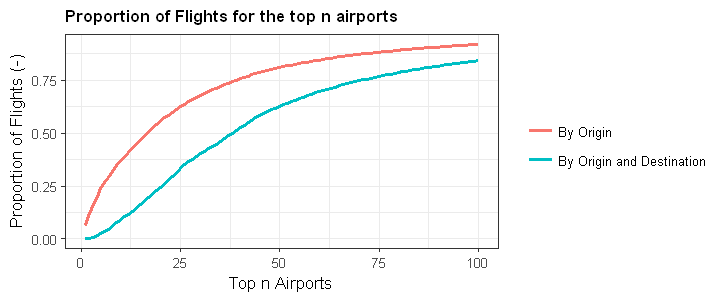

In [20]:
#Plot of percentage of origin flights vs. number of airports

numAirports = seq(1,100,by = 1)
percentageOfOriginFlights = rep(NA, times = length(numAirports))
percentageOfOriginAndDest = rep(NA, times = length(numAirports))
plotdf = data.frame(numAirports, percentageOfOriginFlights, percentageOfOriginAndDest)
plotdf$percentageOfOriginAndDest = proportionInBothOrigAndDest[1:100]
for (i in 1:100) {
  plotdf[i,2] = sum(originTable[1:i])/nrow(flights)
}
#head(plotdf)

#head(plotdf)
library(cowplot)

colnames(plotdf) = c("numAirports", "By Origin", "By Origin and Destination")
d = ggplot(data = melt(plotdf, id.var = "numAirports"),
           aes(x = numAirports, y = value)) + 
      geom_line(aes(color = variable, group = variable), size = 1.0) +
labs(x  = 'Top n Airports', y = 'Proportion of Flights (-)') + theme_bw(base_size=10) + 
ggtitle('Proportion of Flights for the top n airports') +
theme(legend.title = element_blank(), plot.title = element_text(size = 10, face = "bold"))
options(repr.plot.width=6, repr.plot.height=2.5)
d

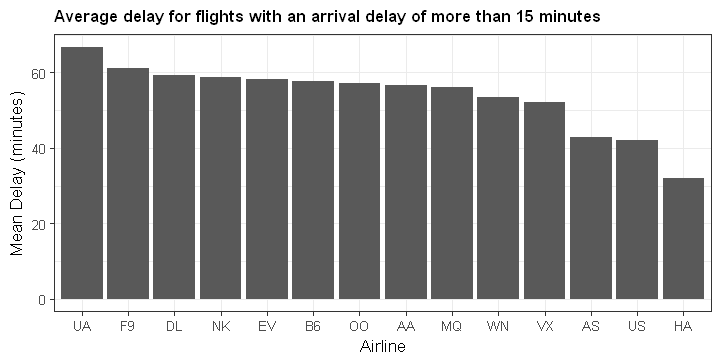

In [21]:
delayedFlights = flights[(flights$ARRIVAL_DELAY > 15), ]

delayedByAirline = delayedFlights %>%
  group_by(AIRLINE) %>%
  summarise(
    n = n(),
    delaytime = mean(DEPARTURE_DELAY, na.rm = TRUE)
  ) %>%
  ungroup() %>%
  arrange(desc(delaytime))
delayedByAirline = as.data.frame(delayedByAirline)
options(repr.plot.width=6, repr.plot.height=3)

delayedByAirline$AIRLINE = factor(delayedByAirline$AIRLINE, levels = delayedByAirline$AIRLINE)
ggplot(data=na.omit(delayedByAirline), aes(x=AIRLINE, y=delaytime)) +
  geom_bar(stat="identity") + theme_bw(base_size=10) + 
ggtitle('Proportion of Flights for the top n airports') +
xlab('Airline') + ylab('Mean Delay (minutes)') + 
ggtitle('Average delay for flights with an arrival delay of more than 15 minutes') +
theme(legend.title = element_blank(), plot.title = element_text(size = 10, face = "bold"))

In [22]:
delayThreshold = 30
delaysGreaterThan30ByAirline = flights %>%
  group_by(AIRLINE) %>%
  summarise(
    n = n(),
    delayedNum = length(DEPARTURE_DELAY[DEPARTURE_DELAY > delayThreshold & !is.na(DEPARTURE_DELAY)]),
    delayedFrac = delayedNum/n
  ) %>%
  ungroup() %>%
  arrange(desc(delayedFrac))

delaysGreaterThan30ByOrigin = flights %>%
  group_by(ORIGIN_AIRPORT) %>%
  summarise(
    n = n(),
    delayedNum = length(DEPARTURE_DELAY[DEPARTURE_DELAY > delayThreshold & !is.na(DEPARTURE_DELAY)]),
    delayedFrac = delayedNum/n
  ) %>%
  ungroup() %>%
  arrange(desc(n))

In [23]:
flights$DATE = as.Date(paste(flights$YEAR, 
                             flights$MONTH, 
                             flights$DAY, 
                             sep = "-"), format="%Y-%m-%d")
allFlightsByDay = split(flights, flights$DATE)
delayedFlights$DATE = as.Date(paste(delayedFlights$YEAR, 
                                    delayedFlights$MONTH, 
                                    delayedFlights$DAY, 
                                    sep = "-"), format="%Y-%m-%d")
flightsByDay = split(delayedFlights, delayedFlights$DATE)
allFlightsByDay_vec = unlist(lapply(allFlightsByDay, nrow))
numDelayByDay = unlist(lapply(flightsByDay, nrow))
delayFracByDay = numDelayByDay/allFlightsByDay_vec

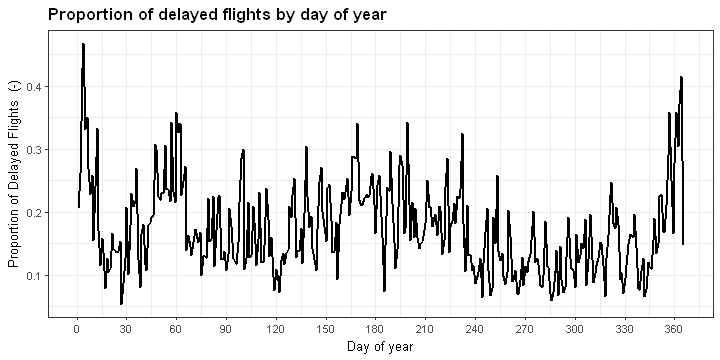

In [24]:
delayByDay.DF = as.data.frame(delayFracByDay)
delayByDay.DF$index = seq(1, nrow(delayByDay.DF))
#head(delayByDay.DF)
plotByDay = ggplot(delayByDay.DF, aes(x = index)) + 
geom_line(aes(y=delayFracByDay), size = 0.6) +
labs(x  = 'Day of year', y = 'Proportion of Delayed Flights  (-)') + 
ggtitle('Proportion of delayed flights by day of year') +
theme_bw(base_size=8) + 
theme(plot.title = element_text(size = 10, face = "bold")) + 
scale_x_continuous(breaks = seq(0, 365, by = 30))
plotByDay

In [25]:
#most delayed Routes for flights longer than 100 miles
delayedFlights = flights[(flights$ARRIVAL_DELAY > 30) & (flights$DISTANCE > 100), ]
mostDelayedRoutes = delayedFlights %>%
  group_by(ORIGIN_AIRPORT, DESTINATION_AIRPORT) %>%
  summarise(meanDelay = mean(ARRIVAL_DELAY)) %>%
  arrange(desc(meanDelay))

In [26]:
#most delayed routes due to weather
mostDelayedWeatherRoutes = delayedFlights %>%
  group_by(ORIGIN_AIRPORT, DESTINATION_AIRPORT) %>%
  summarise(meanDelay = mean(WEATHER_DELAY)) %>%
  arrange(desc(meanDelay))

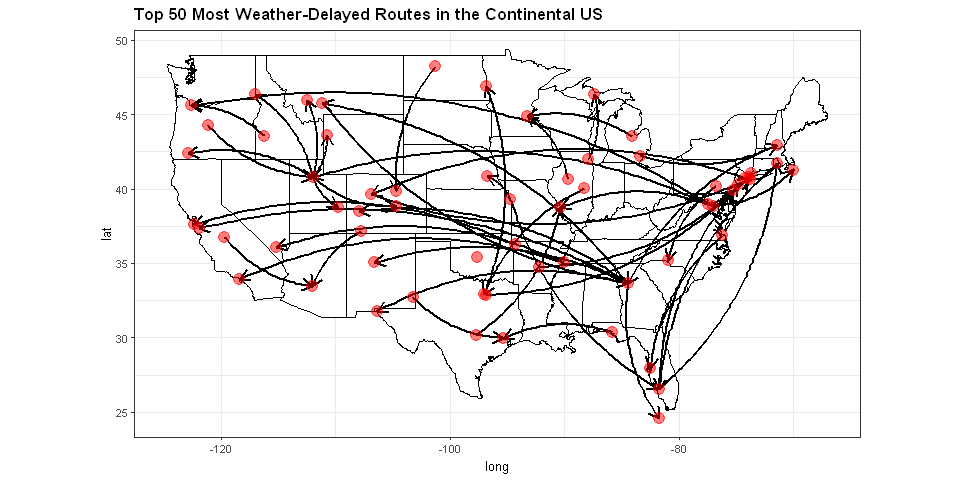

In [27]:
#Create a map of the top 50 routes that most frequently receive weather delays
mostDelayedWeatherRoutes = as.data.frame(mostDelayedWeatherRoutes)
mostDelayedWeatherRoutes = mostDelayedWeatherRoutes[1:50,]
mostDelayedWeatherRoutes$OriginLongitude = NA
mostDelayedWeatherRoutes$OriginLatitude = NA
mostDelayedWeatherRoutes$DestLongitude = NA
mostDelayedWeatherRoutes$DestLatitude = NA

airportLocations = read.table("data/airports_withtimezone.txt", header = T, sep = "\t", quote = "", comment.char = "")

for (i in 1:50) {
  origin = as.character(mostDelayedWeatherRoutes$ORIGIN_AIRPORT[i])
  destination = as.character(mostDelayedWeatherRoutes$DESTINATION_AIRPORT[i])
  
  mostDelayedWeatherRoutes$OriginLongitude[i] = airportLocations[as.character(airportLocations$IATA_CODE) == origin, 7]
  mostDelayedWeatherRoutes$OriginLatitude[i] =  airportLocations[as.character(airportLocations$IATA_CODE) == origin, 6]
  mostDelayedWeatherRoutes$DestLongitude[i] = airportLocations[as.character(airportLocations$IATA_CODE) == destination, 7]
  mostDelayedWeatherRoutes$DestLatitude[i] =  airportLocations[as.character(airportLocations$IATA_CODE) == destination, 6]
}

locationPointsDF = data.frame(AirportCode = character(),
                              Longitude = double(),
                              Latitude = double(), stringsAsFactors = FALSE)
for (i in 1:50) {
  locationPointsDF[i,1] = as.character(mostDelayedWeatherRoutes[i,1])
  locationPointsDF[i,2] = mostDelayedWeatherRoutes[i,4]
  locationPointsDF[i,3] = mostDelayedWeatherRoutes[i,5]
}
for (i in 51:100) {
  locationPointsDF[i,1] = as.character(mostDelayedWeatherRoutes[(i-50),2])
  locationPointsDF[i,2] = mostDelayedWeatherRoutes[(i-50),6]
  locationPointsDF[i,3] = mostDelayedWeatherRoutes[(i-50),7]
}
locationPointsDF = unique(locationPointsDF)

options(repr.plot.width=8, repr.plot.height=4)

locationPointsDF = locationPointsDF[locationPointsDF$Longitude >= -125,]
mostDelayedWeatherRoutes_subset = mostDelayedWeatherRoutes[mostDelayedWeatherRoutes$OriginLongitude >= -125 &
                                                           mostDelayedWeatherRoutes$DestLongitude >= -125, ]
mostDelayedWeatherRoutes_subset = mostDelayedWeatherRoutes_subset[-c(31),]
usa <- map_data("state")
gg1 <- ggplot() + geom_polygon(data = usa, aes(x = long, y = lat, group = group), 
                               fill = "white", col = "black") + coord_fixed(1.3) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))
gg1 + geom_curve(data=mostDelayedWeatherRoutes_subset,
                 aes(x=OriginLongitude, y=OriginLatitude, 
                     xend=DestLongitude, yend=DestLatitude),
                 col="black",
                 size=0.6,
                 curvature=0.2, arrow =arrow(length = unit(0.03, "npc"))) +
  geom_point(data = locationPointsDF, 
             aes(x = Longitude, y = Latitude), 
             color = "red", size = 3, alpha = 0.5) +
  ggtitle('Top 50 Most Weather-Delayed Routes in the Continental US') + 
  theme_bw(base_size = 8) +
  theme(plot.title = element_text(size=10, face = "bold"))


### Combine flight delay data and weather data for use with tensorFlow

Weather data for the top 50 most popular airports was obtained from the IOWA Environmental Mesonet (one file per station).
https://mesonet.agron.iastate.edu/request/download.phtml
The following code combines the files into a single 'Weather' dataframe. 

Note, the timeseries interval varies within each file and across files.

In [28]:
#weatherDataAirports = origDestFreqTable[1:50,1]

#all2015WeatherData = data.frame(station = character(),
#                                dateTime = as.Date(character()),
#                                temperature = as.numeric(),
#                                dewPoint = as.numeric(),
#                                relHumidity = as.numeric(),
#                                windDirection = as.numeric(),
#                                windSpeed = as.numeric(),
#                                rainfallInches = as.numeric(),
#                                altimeter = as.numeric(),
#                                seaLevelPressure = as.numeric(),
#                                visibility = as.numeric(),
#                               windGusts = as.numeric())

#for (i in 1:length(weatherDataAirports)) {
#  airport = as.character(weatherDataAirports[i])
#
#  filename = paste("data/asos_", airport, "_2015to2016.txt", sep = "")
#  weatherData = read.csv(file(filename), header = T)
#  if (ncol(weatherData) == 1) {
#    weatherData = read.table(file(filename), header=T, sep="\t")
#  }
#  # Remove unnecessary columns and rename columns for clarity
#  weatherData = subset(weatherData, select = -c(lon, lat, metar, skyc1, skyc2, skyc3, skyc4, 
#                                                skyl1, skyl2, skyl3, skyl4, wxcodes))
#  colnames(weatherData) = colnames(all2015WeatherData)
#    
#  # Select only 2015 data  
#  weatherData$dateTime =  as.POSIXct(weatherData$dateTime, format="%Y-%m-%d %H:%M")
#  weatherData_2015 = weatherData[weatherData$dateTime < as.POSIXct("2016-01-01 00:00"),]
#  print(nrow(weatherData_2015))
#
#  weatherData_2015[weatherData_2015 == "M"] = NA
#  print(sapply(weatherData_2015, function(x) sum(!(is.na(x)))))
#  all2015WeatherData = rbind(all2015WeatherData, weatherData_2015)
#}

# write.table(all2015WeatherData, file ="CombinedWeatherData_2015FlightDelay.txt", append = F,
#             sep = "\t", na = "", row.names = F, col.names = T)
weatherData = read.table(file("data/CombinedWeatherData_2015FlightDelay.txt"), sep = "\t", header = T,
                        stringsAsFactor = FALSE)

In [29]:
#Prepare the date/time columns in the flights dataframe for joining with weather data 

flights$SCHEDULED_DEPARTURE = combineDateTime(flights$YEAR, 
                                              flights$MONTH, 
                                              flights$DAY, 
                                              flights$SCHEDULED_DEPARTURE)
flights$SCHEDULED_ARRIVAL = combineDateTime(flights$YEAR, 
                                            flights$MONTH, 
                                            flights$DAY, 
                                            flights$SCHEDULED_ARRIVAL)

In [30]:
drops = c("FLIGHT_NUMBER", "TAIL_NUMBER", "DEPARTURE_TIME", "DEPARTURE_DELAY",
          "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME", "AIR_TIME", 
          "ELAPSED_TIME", "WHEELS_ON", "TAXI_IN","ARRIVAL_TIME", 
          "DIVERTED", "CANCELLED", "CANCELLATION_REASON", "AIR_SYSTEM_DELAY",
          "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY")
flights = flights[, !(names(flights) %in% drops)]

In [31]:
#Add timezone data for arrival and departure times (All weather data is UTC but flight times are local)

airports = read.table(file("data/airports_withtimezone.txt"), 
                      header = T, sep = "\t", quote = "", comment.char = "")
#nrow(airports)

# Join flight dataset by airport code to add timezone
timezoneDF = airports[,c("IATA_CODE", "DavidOlson_TIMEZONE")]
colnames(timezoneDF) = c("ORIGIN_AIRPORT", "TIMEZONE")
flights = join(flights, timezoneDF, by = "ORIGIN_AIRPORT")
colnames(flights)[colnames(flights)=="TIMEZONE"] = "ORIGIN_TZ"

colnames(timezoneDF) = c("DESTINATION_AIRPORT", "TIMEZONE")
flights = join(flights, timezoneDF, by = "DESTINATION_AIRPORT")
colnames(flights)[colnames(flights)=="TIMEZONE"] = "DESTINATION_TZ"

In [32]:
rollingJoinWeatherData = function(weatherDF, flightsDF) {
    
  weatherDF$dateTime = as.character(weatherDF$dateTime)
  weatherDF$dateTime = as.POSIXct(weatherDF$dateTime, format="%Y-%m-%d %H:%M", tz = "UTC")
  weatherDF = as.data.table(weatherDF)
  flightsDF = as.data.table(flightsDF)
  flightsDF[, join_time:=SCHEDULED_DEPARTURE_UTC]
  weatherDF[, join_time:=dateTime]
  colnames(flightsDF)[colnames(flightsDF)=="ORIGIN_AIRPORT"] = "station"
  
  setkey(weatherDF, station, join_time)
  setkey(flightsDF, station, join_time)
  joinedData = weatherDF[flightsDF, roll = "nearest"]
  colnames(joinedData)[colnames(joinedData)=="station"] = "ORIGIN_AIRPORT"
  joinedData$dateTime = NULL
  joinedData$join_time = NULL
  return(joinedData)
}

In [33]:
flights_UTC = flights
flights_UTC$SCHEDULED_DEPARTURE = as.character(flights$SCHEDULED_DEPARTURE)
flights_UTC$SCHEDULED_DEPARTURE_UTC = as.POSIXct(flights$SCHEDULED_DEPARTURE,
                                                 tz = flights$ORIGIN_TZ)
attributes(flights_UTC$SCHEDULED_DEPARTURE_UTC)$tzone = "UTC"
flights_UTC$SCHEDULED_ARRIVAL = as.character(flights$SCHEDULED_ARRIVAL)
flights_UTC$SCHEDULED_ARRIVAL_UTC = as.POSIXct(flights$SCHEDULED_ARRIVAL, 
                                               tz = flights_UTC$DESTINATION_TZ)
attributes(flights_UTC$SCHEDULED_ARRIVAL_UTC)$tzone = "UTC"

In [34]:
weatherStations = unique(weatherData$station)
#head(weatherStations)
subsetFlights = flights_UTC[(flights_UTC$ORIGIN_AIRPORT %in% weatherStations) & 
                            (flights_UTC$DESTINATION_AIRPORT %in% weatherStations),]
cat('Total flights for model building:', nrow(subsetFlights))

Total flights for model building: 3462514

In [35]:
joinedData = rollingJoinWeatherData(weatherData, subsetFlights)
cat('Joined data column names:')
colnames(joinedData)


Joined data column names:

[1] "ORIGIN_AIRPORT"          "temperature"            
 [3] "dewPoint"                "relHumidity"            
 [5] "windDirection"           "windSpeed"              
 [7] "rainfallInches"          "altimeter"              
 [9] "seaLevelPressure"        "visibility"             
[11] "windGusts"               "YEAR"                   
[13] "MONTH"                   "DAY"                    
[15] "DAY_OF_WEEK"             "AIRLINE"                
[17] "DESTINATION_AIRPORT"     "SCHEDULED_DEPARTURE"    
[19] "DISTANCE"                "SCHEDULED_ARRIVAL"      
[21] "ARRIVAL_DELAY"           "departureHour"          
[23] "DATE"                    "ORIGIN_TZ"              
[25] "DESTINATION_TZ"          "SCHEDULED_DEPARTURE_UTC"
[27] "SCHEDULED_ARRIVAL_UTC"